In [55]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [56]:
# Cargamos el csv original
raw_file = '~/Desktop/Proyecto/raw/airbnb-listings.csv'
df = pd.read_csv(raw_file, delimiter=";", low_memory=False)

# Proyecto Final para el Bootcamp Mujeres en Tech - KeepCoding
- - -
En este proyecto exploraremos el [*dataset*](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets) propuesto y responderemos algunas preguntas que nos hemos planteado.

Trataremos con datos de Airbnb e intentaremos averiguar que datos tienen mayor impacto en el precio de las propiedades ofrecidas en alquiler.

Para eso tendremos que seguir algunos pasos:

## 1. Muestreo y exploración inicial de los datos:
### ¿Con que datos trabajaremos?

Hemos decidido trabajar con los datos de *Madrid*. Por lo que procederemos a quedarnos con esos datos específicos y posteriormente filtrar las columnas que creemos que serán útiles.

In [57]:
# Filtramos las filas y nos quedamos solo con las que contienen datos de Madrid
madrid_condition = df['State'].astype(str).str.contains('Madrid')
df = df[madrid_condition]

Elegimos las columnas listadas a continuación:

In [58]:
# Variable con las columnas que vamos a utilizar
columns_to_keep = ['ID', 'Host ID', 'Host Since', 'Neighbourhood', 'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude', 'Longitude', \
                   'Amenities', 'Property Type', 'Room Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee', 'Availability 365', \
                   'Review Scores Location', 'Cancellation Policy', 'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price', 'Monthly Price', 'Weekly Price']

# Nos quedamos solo con las columnas elegidas
df = df[columns_to_keep]
print(df.columns)

Index(['ID', 'Host ID', 'Host Since', 'Neighbourhood',
       'Neighbourhood Cleansed', 'City', 'State', 'Zipcode', 'Latitude',
       'Longitude', 'Amenities', 'Property Type', 'Room Type', 'Bathrooms',
       'Bedrooms', 'Beds', 'Bed Type', 'Square Feet', 'Cleaning Fee',
       'Availability 365', 'Review Scores Location', 'Cancellation Policy',
       'Accommodates', 'Reviews per Month', 'Minimum Nights', 'Price',
       'Monthly Price', 'Weekly Price'],
      dtype='object')


## 2. Normalización de las columnas

Algunas columnas tienen datos que no estan normalizados, como por ejemplo el código postal y el barrio.


In [59]:
# Normalizamos los valores de la columna Zipcode que contiene códigos postales erróneos y valores nulos
replace_values = {'nan': np.nan, '-': np.nan, '28': np.nan, '-' : np.nan, '2802\n28012' : '28012', '28002\n28002': '28002', '28051\n28051' : '28051', \
                  'Madrid 28004': '28004', '2815' : '28015', '2805' : '28005'}

df = df.replace({'Zipcode': replace_values})

En el caso del barrio, esta columna tenía muchos valores nulos. Nuestra decisión fue rellenar los nulos con los encontrados en la columna Neighbourhood Cleansed y luego descartar esta columna.

In [60]:
# Cambiamos los valores nulos de la columna Neighbourhood por el valor correspondiente de la columna Neighbourhood Cleansed
df['Neighbourhood'] = df['Neighbourhood'].fillna(df['Neighbourhood Cleansed'])

# Eliminamos la columna Neighbourhood Cleansed
df = df.drop('Neighbourhood Cleansed', axis = 1)

# Comprobamos que no quedan valores nulos
df['Neighbourhood'].isna().value_counts()

False    13198
Name: Neighbourhood, dtype: int64

### Columnas de texto
---

Vamos a analizar las columnas que son cadenas de texto y a quitar tildes, dobles espacios, ect



In [61]:
# Analizamos qué columnas necesitan normalización textual
for column in df.columns:
    if df[column].dtype == object:
        print(column)

# Variable con dichas columnas
str_columns = ['Neighbourhood', 'City', 'State', 'Property Type', 'Room Type', 'Bed Type', 'Cancellation Policy']

# Analizamos los caracteres no alfabéticos a conservar o a eliminar
for column in df.columns:
    if column in str_columns:
        temp_df = df[df[column].astype(str).str.contains('-|#|\.|,|;|:|_|&|/|Ç|\'|%|[|]|{|}|=|\?|¿|\(|\)|¡|!|\$|`\´|>|<|\||ª|º\\|@|\d|  ')]
        print(temp_df[column].unique())

# Función para eliminar los caracteres no alfa-numéricos y los dobles espacios
def no_alfa_num(text):
    characters = '-|_|\(|\)|  '
    for character in text:
        match = re.search(characters, text)
        if match:
            text = text.replace(match.group(0), ' ')
    return text

# Función para normalizar tildes y eñes
def normalize(text):
    characters = (('á', 'a'), ('é', 'e'), ('í', 'i'), ('ó', 'o'), ('ú', 'u'), ('ñ', 'n'))
    for a, b in characters:
        text = text.replace(a, b).replace(a.upper(), b.upper())
    return text

# Normalización de las columnas de texto
for column in df.columns:
    if column in str_columns:
        column_normalized = list(map(normalize, list(map(no_alfa_num, df[column].astype(str)))))
        df[column] = column_normalized

df[str_columns]

ID
Host Since
Neighbourhood
City
State
Zipcode
Amenities
Property Type
Room Type
Bed Type
Cancellation Policy
['Fuencarral-el Pardo' 'Fuencarral-El Pardo']
['Delicias-Madrid' 'Madrid, Comunidad de Madrid, ES' 'Centro, Madrid'
 'las matas  madrid' 'Madrid, Comunidad de Madrid, ESPANA'
 'Madrid, Vallecas (Fontarrón)' 'Aravaca (Madrid)' 'Chueca, Madrid']
['Madrid, Spain' 'España,Madrid']
['Bed & Breakfast' 'Camper/RV']
['Entire home/apt']
['Pull-out Sofa']
['super_strict_60' 'super_strict_30']


,Neighbourhood,City,State,Property Type,Room Type,Bed Type,Cancellation Policy
1021,Embajadores,Madrid,Comunidad de Madrid,Loft,Entire home/apt,Real Bed,moderate
1022,Embajadores,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,strict
1023,Embajadores,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,moderate
1024,Embajadores,Madrid,Community of Madrid,Apartment,Entire home/apt,Real Bed,strict
1025,Embajadores,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,strict
...,...,...,...,...,...,...,...
492516,Cortes,Centro,Madrid,Apartment,Private room,Futon,moderate
492517,Cortes,Madrid,Madrid,Apartment,Entire home/apt,Real Bed,flexible
492518,Cortes,Madrid,Comunidad de Madrid,Apartment,Private room,Real Bed,strict
492519,Cortes,Madrid,Comunidad de Madrid,Apartment,Entire home/apt,Real Bed,moderate


### Conversión de tipos de datos
---

Algunos datos estaban en tipos incorrectos para su manejo, también hicimos las correcciones pertinentes.

- Host_Since a tipo fecha:

In [62]:
# Conversión de las fechas de 'Host Since' en date
df['Host Since'] = pd.to_datetime(df['Host Since'])

- ID de la propiedad a numérico en vez de string.

In [63]:
# Conversión del ID de la entrada en numérico en vez de string
df['ID'] = df['ID'].astype(int)

- El dataset scrapeado tenia una columna en pies cudrados. Decidimos convertirla en metros cuadrados para tener una mejor comprensión de la métrica.

In [64]:
df['Square Meters'] = df['Square Feet'] / 10.764
df['Square Meters']

1021     NaN
1022     NaN
1023     NaN
1024     NaN
1025     NaN
          ..
492516   NaN
492517   NaN
492518   NaN
492519   NaN
492520   NaN
Name: Square Meters, Length: 13198, dtype: float64

### Property Type
---

En el caso de esta variable, notamos que habia demasiadas clasificaciones con muy pocos registros, así que decidimos quedarnos con lo más relevante y agrupar el resto como "Otros".

Al ejecutar la siguiente celda se puede ver un gráfico en donde es obvio que la mayoría de las propiedades ofrecidas son *APARTAMENTOS*.

<AxesSubplot: >

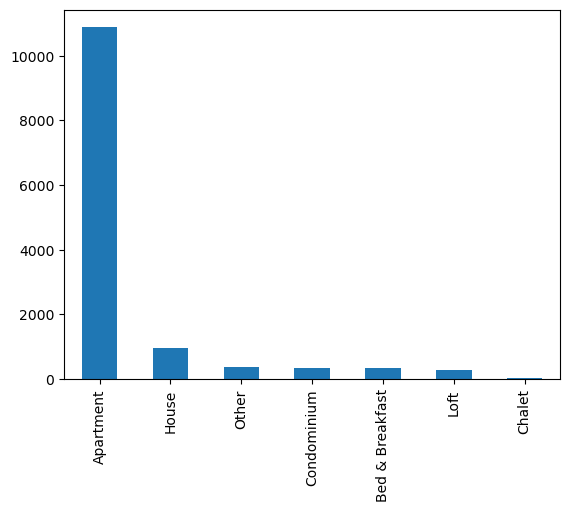

In [65]:
# Variable con los valores de Property Type que nos interesan (más comunes)
valid_property_types = ['House', 'Apartment', 'Bed & Breakfast', 'Condominium', 'Loft', 'Chalet', 'Hostal']
# Agrupamos los valores de Property Type y creamos un valor Other para el resto
property_types = df['Property Type']
property_types = property_types.map(lambda value: value if value in valid_property_types else 'Other')
df['Property Type'] = property_types
# Visualizamos el resultado
df['Property Type'].value_counts().plot.bar()

### Amenities
---

Aquí realmente basamos nuestras principales dudas sobre el dataset

Estabamos interesadas en conocer si habia alguna amenidad que influyese en el precio o si el numero total de amenidades tenia algun impacto

Primero decidimos revisar cuales eran mas amenidades más frecuentes.

In [66]:
#Creamos un nuevo DataFrame, con columnas que corresponden a cada Amenity
df_amenities = df.Amenities.fillna('').str.get_dummies(sep=',').astype(bool)
df_amenities

,24-hour check-in,Air conditioning,Baby bath,Babysitter recommendations,Bathtub,Breakfast,Buzzer/wireless intercom,Cable TV,Carbon monoxide detector,Cat(s),...,Suitable for events,TV,Table corner guards,Washer,Washer / Dryer,Wheelchair accessible,Window guards,Wireless Internet,translation missing: en.hosting_amenity_49,translation missing: en.hosting_amenity_50
1021,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,True,True,True
1022,True,True,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False
1023,False,True,False,False,False,False,True,False,True,False,...,False,True,False,True,False,False,False,True,False,False
1024,False,True,False,False,False,False,False,True,False,False,...,False,True,False,True,False,False,False,True,False,False
1025,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492516,False,True,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,True,True
492517,True,True,False,False,False,False,True,False,True,False,...,False,True,False,True,False,True,False,True,False,False
492518,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
492519,True,True,False,False,False,False,True,False,False,False,...,False,True,False,True,False,False,False,True,False,False


<AxesSubplot: title={'center': 'Frecuencia de las Amenities más Comunes'}, xlabel='Amenities', ylabel='Frecuencia'>

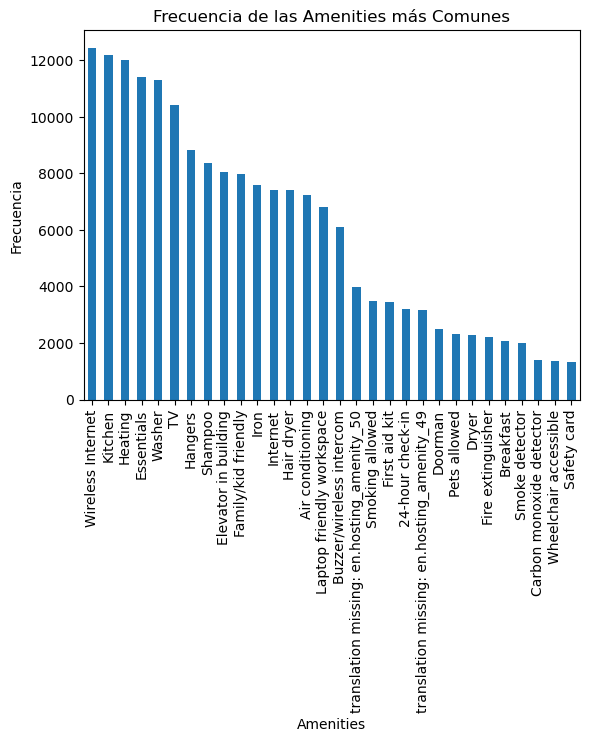

In [67]:
#Calculo de la frecuencia de las Amenities
df_amenities_frequency = pd.DataFrame()
for column in df_amenities.columns:
    df_amenities_frequency[column] = df_amenities[column].value_counts()

#Plot de las frecuencias de las Amenities
plt.title("Frecuencia de las Amenities más Comunes")
plt.xlabel("Amenities")
plt.ylabel("Frecuencia")
df_amenities_frequency.transpose()[True].sort_values(ascending=False).head(30).plot.bar()

In [68]:
# df.Amenities.str.get_dummies(',').astype(bool).index#join(df['Price'])[['TV', 'Price']].groupby('TV').mean()
# Laura no me deja borrarlo porque quiere confirmar que el join lo hace por indexacion y así lo conprobamos besis saludos suscribanse i un beso paratodos que diosito los ampare <3
print(';'.join(df['Price'].astype(str).sort_index()) == ';'.join(df_amenities.join(df['Price']).sort_index()['Price'].astype(str)))

True


<AxesSubplot: >

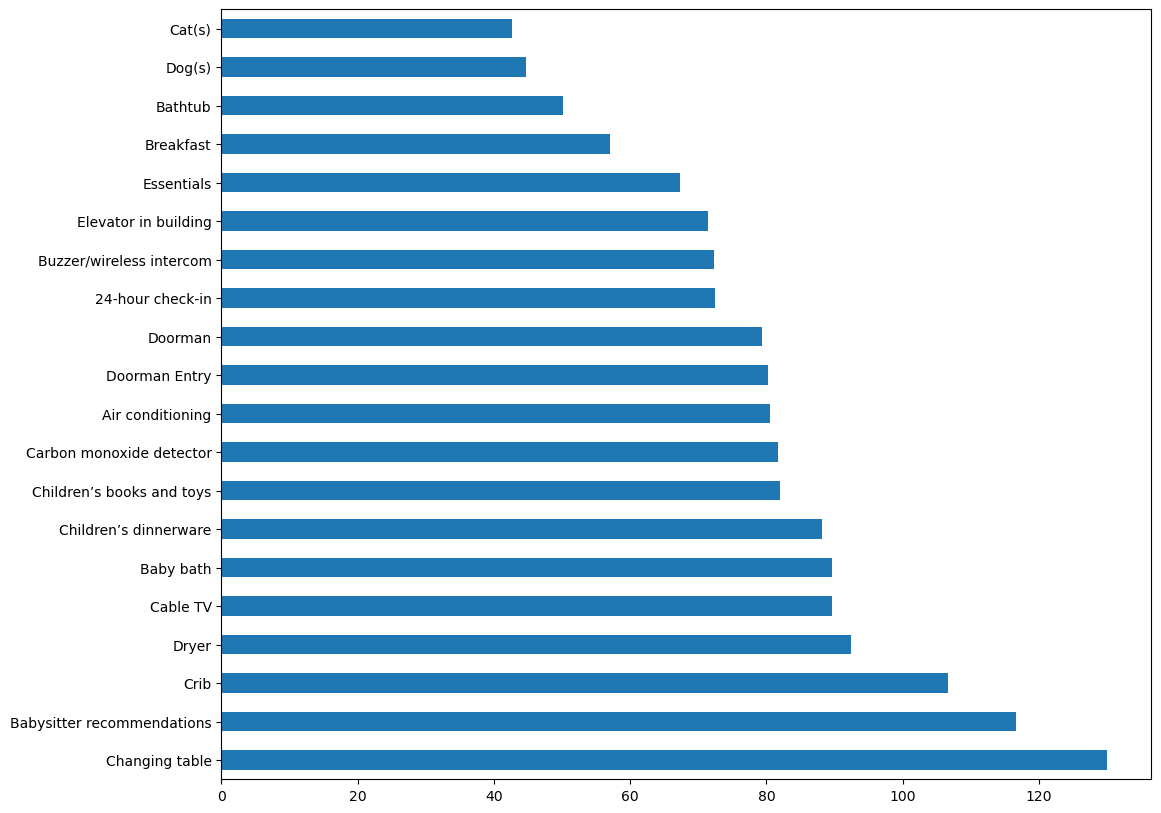

In [69]:
df_amenities_price = df_amenities.join(df['Price'])
df_amenities_price_mean = pd.DataFrame()
for column in df_amenities.columns:
    df_amenities_price_mean[column] = df_amenities_price.groupby(column)['Price'].mean()

df_amenities_price_mean = df_amenities_price_mean.transpose()
df_amenities_price_mean[True].head(20).sort_values(ascending=False).plot.barh(figsize=(12, 10))

In [101]:
df_amenities_price_mean['Diff'] = df_amenities_price_mean[True] - df_amenities_price_mean[False]
df_amenities_price_mean.sort_values(by='Diff', ascending=False).head(20)

24-hour check-in,False,True,Diff
Paid parking off premises,65.710754,165.000000,99.289246
High chair,65.672611,132.416667,66.744055
Changing table,65.723591,130.000000,64.276409
Washer / Dryer,65.711089,124.400000,58.688911
Babysitter recommendations,65.706342,116.571429,50.865087
Indoor fireplace,64.679176,108.263323,43.584147
Crib,65.640094,106.633333,40.993239
Pack ’n Play/travel crib,65.678840,105.611111,39.932271
Air conditioning,47.771644,80.541984,32.770339
Dryer,60.152421,92.365427,32.213006


<AxesSubplot: >

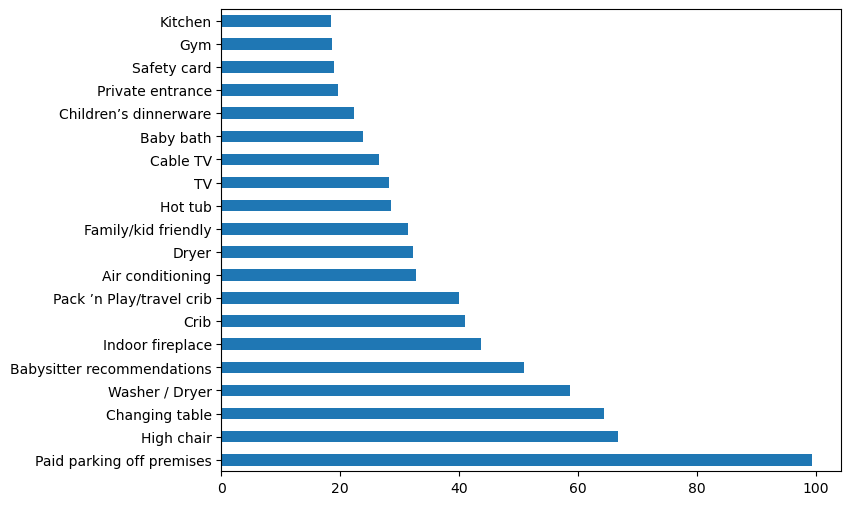

In [96]:
df_amenities_price_mean['Diff'].sort_values(ascending=False).head(20).plot.barh(figsize=(8, 6))

In [71]:
df_amenities_count = pd.DataFrame()
df_amenities_count['Amenities Count'] = df['Amenities'].str.split(',').fillna('').map(lambda x: len(x))
df_amenities_count = df_amenities_count.join(df['Price'])
df_amenities_count

,Amenities Count,Price
1021,15,50.0
1022,16,50.0
1023,18,77.0
1024,10,50.0
1025,10,95.0
...,...,...
492516,19,55.0
492517,22,80.0
492518,10,50.0
492519,17,70.0


<AxesSubplot: xlabel='Amenities Count'>

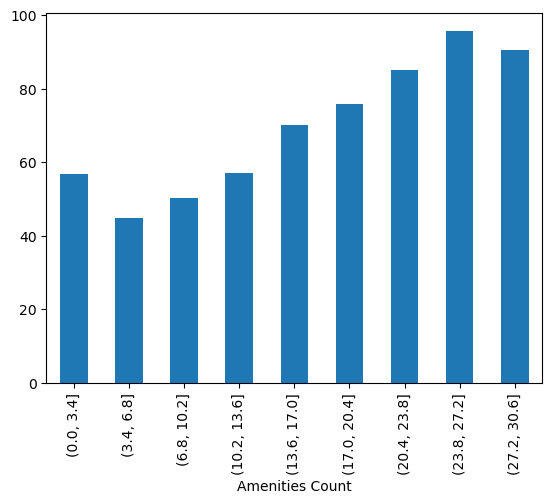

In [72]:
# Visualizamos la variación del precio medio de las propiedades en función de cuántas amenities totales tienen, agrupando el conteo en 10 grupos
steps = 10
max = df_amenities_count['Amenities Count'].max()
stept = max / steps
steps = np.arange(0, max, stept)
groups = pd.cut(df_amenities_count['Amenities Count'], steps)
df_amenities_count.groupby(groups)['Price'].mean().plot.bar()

# Occupancy function

In [73]:

def calculate_ocupacy(reviews_month, min_nights, availability):
    return reviews_month * min_nights * 12 / availability

# Bathrooms

<AxesSubplot: xlabel='Bathrooms'>

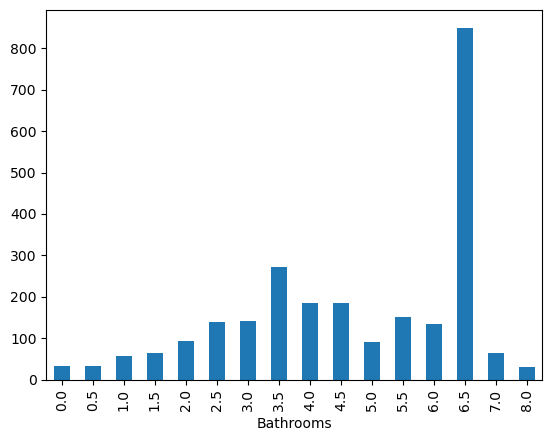

In [74]:
df.groupby('Bathrooms')['Price'].mean().plot.bar()

<AxesSubplot: >

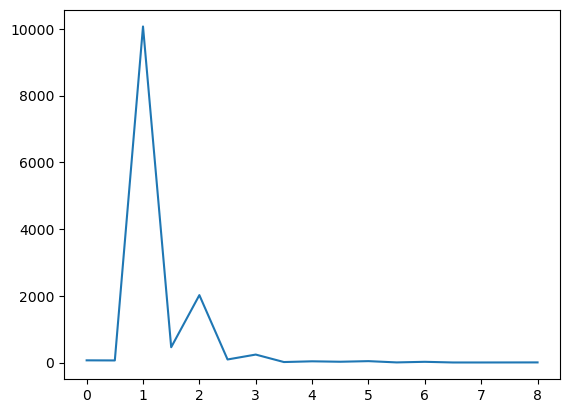

In [75]:
df['Bathrooms'].value_counts().sort_index().plot()

# Bedrooms

<AxesSubplot: xlabel='Bedrooms'>

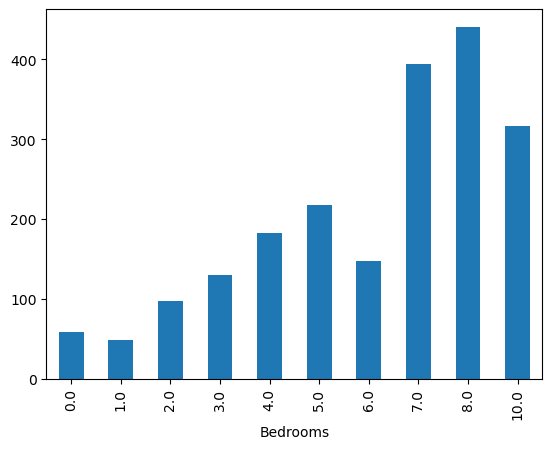

In [76]:
df.groupby('Bedrooms')['Price'].mean().plot.bar()

<AxesSubplot: >

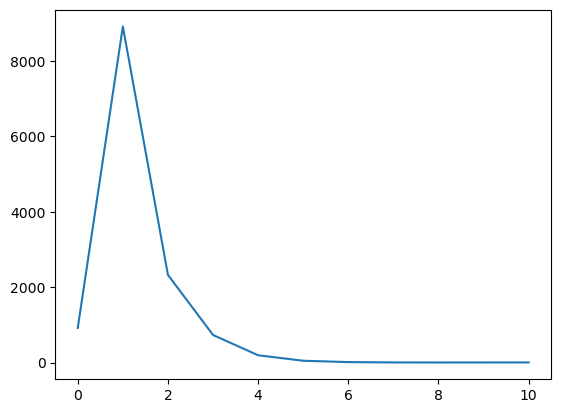

In [77]:
df['Bedrooms'].value_counts().sort_index().plot()

# Beds

<AxesSubplot: xlabel='Beds'>

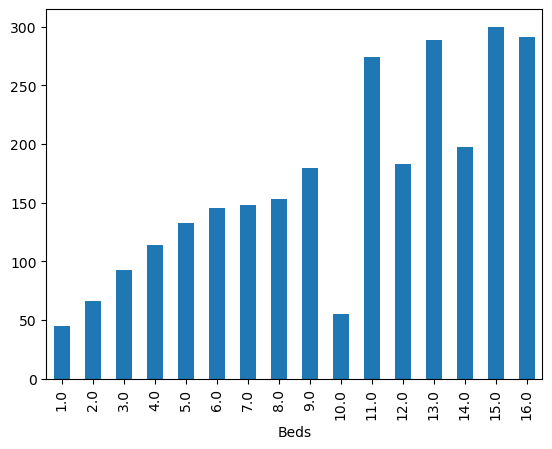

In [78]:
df.groupby('Beds')['Price'].mean().plot.bar()

<AxesSubplot: >

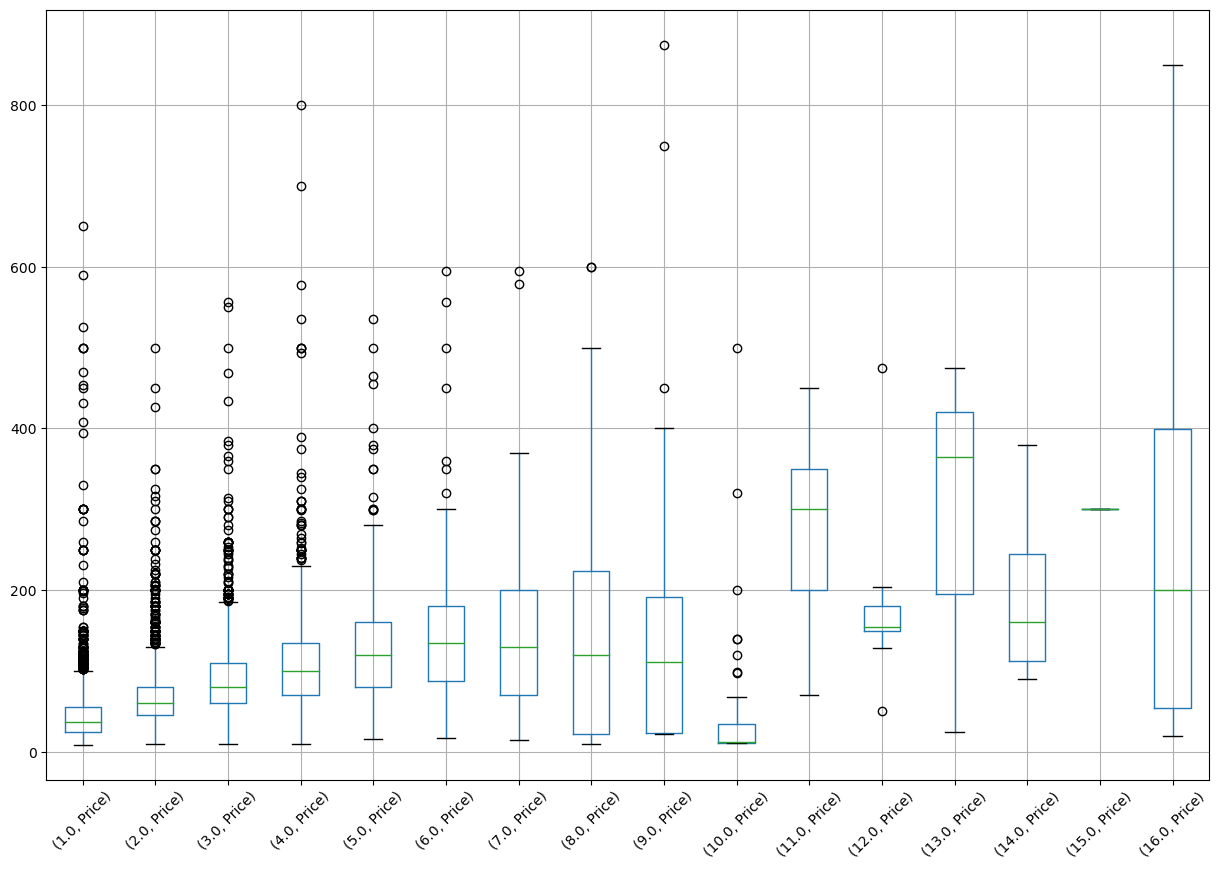

In [79]:
df.groupby('Beds')[['Price']].boxplot(subplots=False, figsize=(15, 10), rot=45)

<AxesSubplot: >

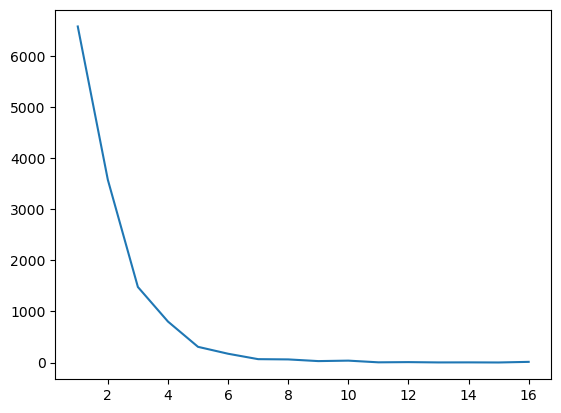

In [80]:
df['Beds'].value_counts().sort_index().plot()

# Ocupacy

<AxesSubplot: xlabel='Ocupacy'>

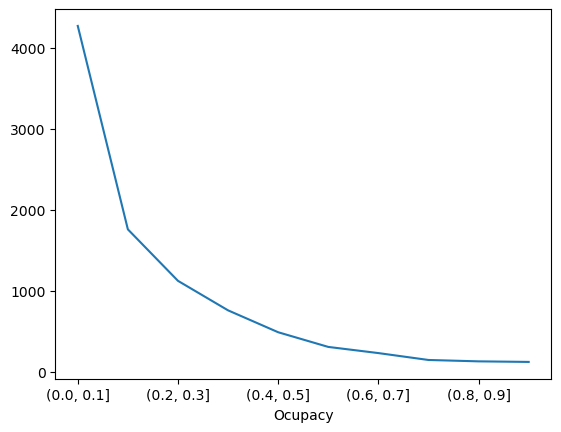

In [81]:
reviews = df['Reviews per Month'].fillna(0)
nights = df['Minimum Nights'].fillna(0)
availability = df['Availability 365'].fillna(0).map(lambda value: value if value != 0 else 9999999)

df['Ocupacy'] = calculate_ocupacy(reviews, nights, availability)

steps = np.arange(0, 1.01, 0.1)
groups = pd.cut(df['Ocupacy'], steps)
df.groupby(groups).size().plot()

# Cleaning Fee

<AxesSubplot: xlabel='Cleaning Fee'>

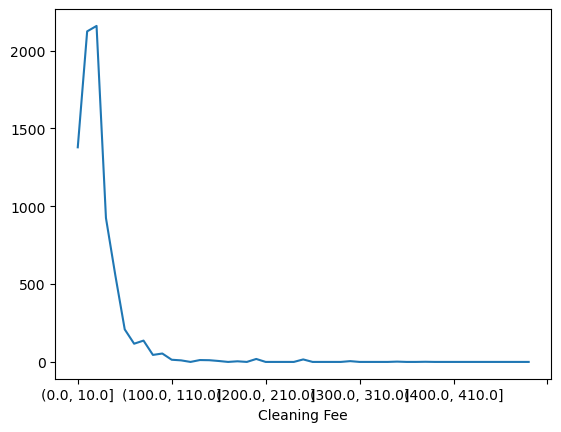

In [82]:
df['Cleaning Fee'] = df['Cleaning Fee'].fillna(0)

steps = 50
stept = df['Cleaning Fee'].max() / steps
steps = np.arange(0, df['Cleaning Fee'].max(), stept)
groups = pd.cut(df['Cleaning Fee'], steps)
df.groupby(groups).size().plot()

<AxesSubplot: xlabel='Neighbourhood'>

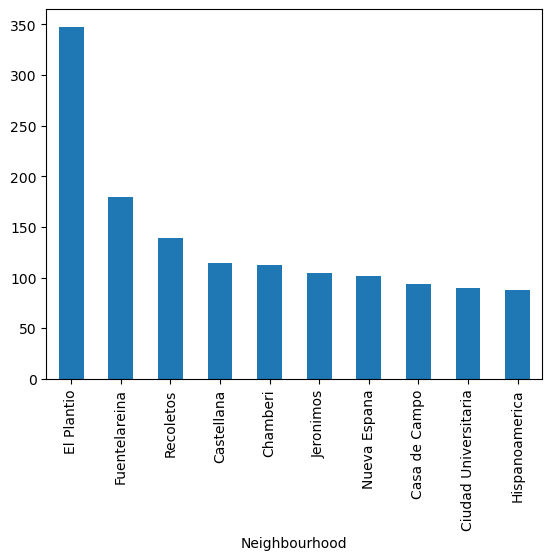

In [83]:
df.groupby('Neighbourhood')['Price'].mean().sort_values(ascending=False).head(10).plot.bar()

<AxesSubplot: xlabel='Neighbourhood'>

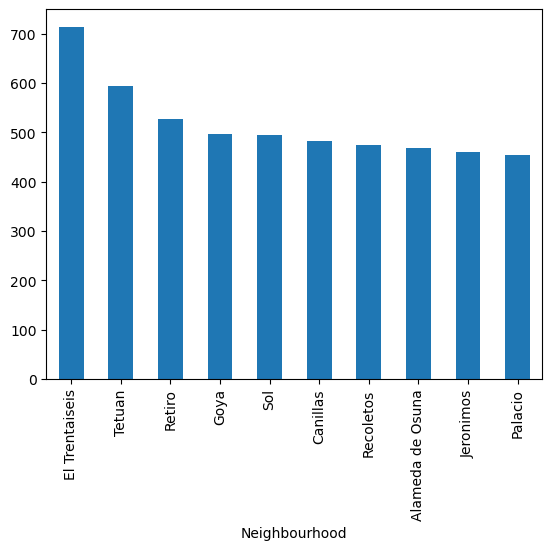

In [84]:
df.groupby('Neighbourhood')['Weekly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

<AxesSubplot: xlabel='Neighbourhood'>

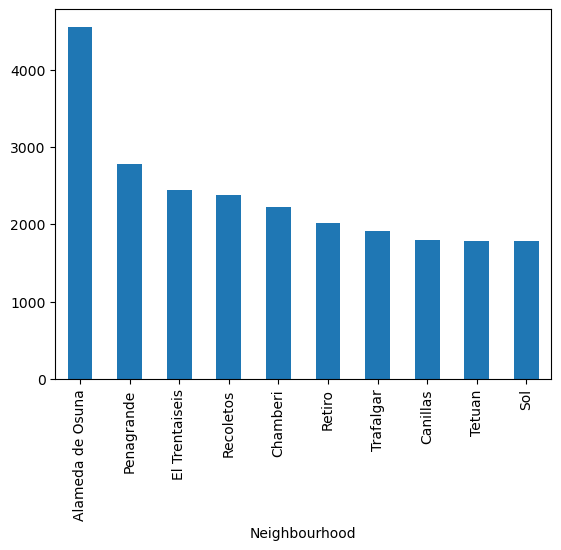

In [85]:
df.groupby('Neighbourhood')['Monthly Price'].mean().sort_values(ascending=False).head(10).plot.bar()

<AxesSubplot: xlabel='Neighbourhood'>

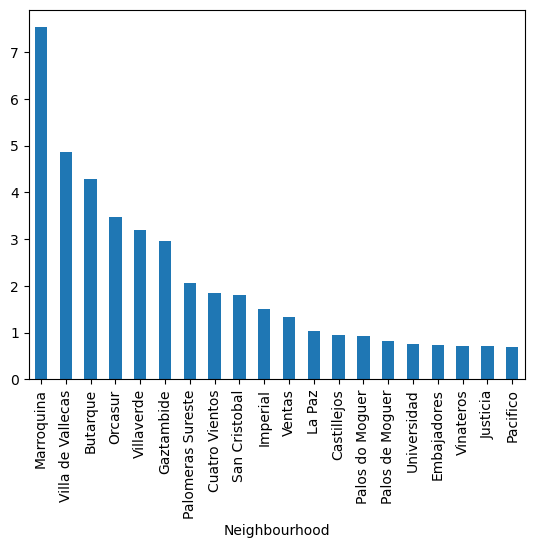

In [86]:
df.groupby('Neighbourhood')['Ocupacy'].mean().sort_values(ascending=False).head(20).plot.bar()

<AxesSubplot: xlabel='Neighbourhood'>

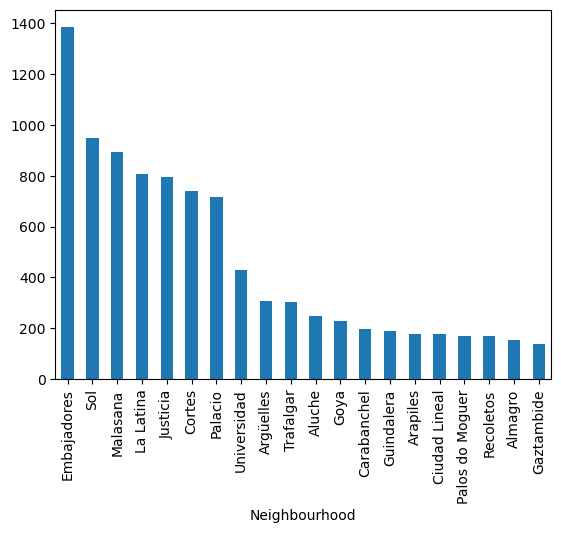

In [87]:
df.groupby('Neighbourhood').size().sort_values(ascending=False).head(20).plot.bar()

<AxesSubplot: xlabel='Square Meters'>

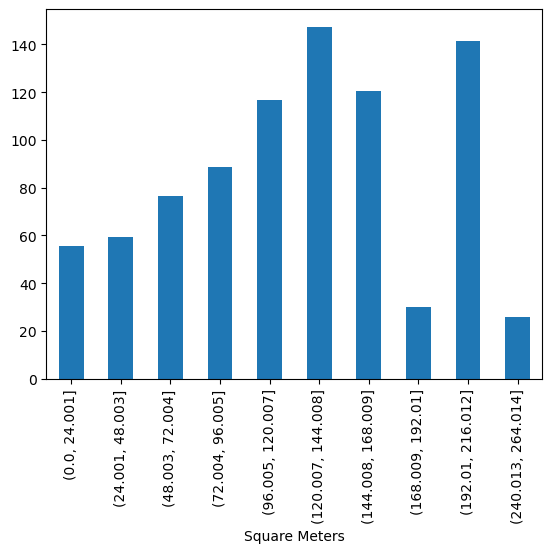

In [88]:
steps = 20
stept = df['Square Meters'].max() / steps
steps = np.arange(0, df['Square Meters'].max(), stept)
groups = pd.cut(df['Square Meters'], steps)
df.groupby(groups)['Price'].mean().dropna().plot.bar()

<AxesSubplot: xlabel='Neighbourhood'>

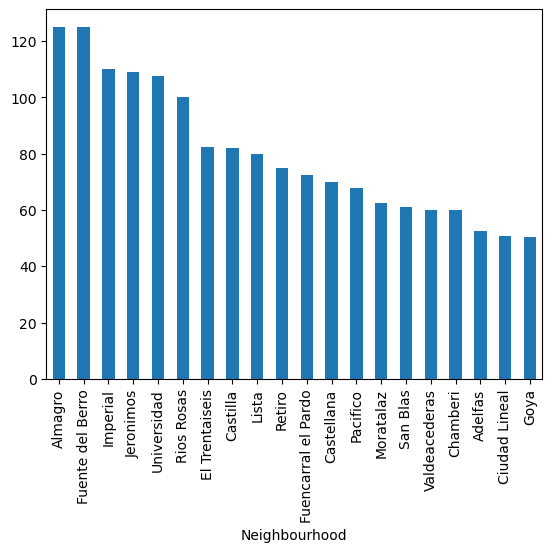

In [89]:
df.groupby('Neighbourhood')['Square Meters'].mean().sort_values(ascending=False).head(20).plot.bar()

<AxesSubplot: xlabel='Neighbourhood'>

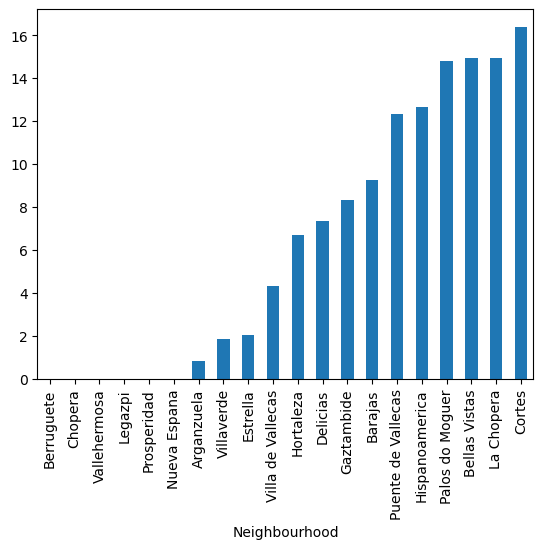

In [90]:
df.groupby('Neighbourhood')['Square Meters'].mean().dropna().sort_values().head(20).plot.bar()

<AxesSubplot: xlabel='Property Type'>

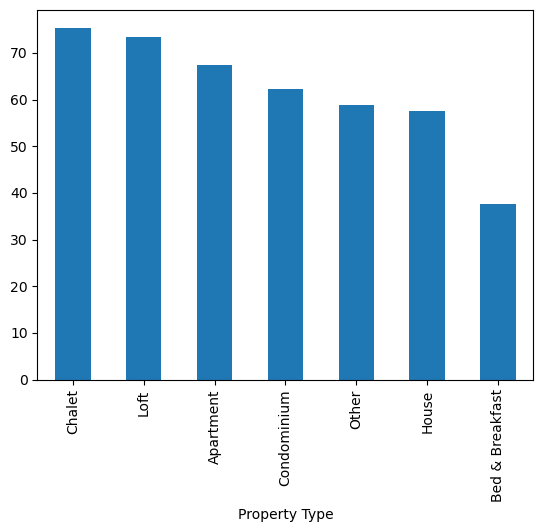

In [91]:
df.groupby(['Property Type'])['Price'].mean().sort_values(ascending=False).head(20).plot.bar()

<AxesSubplot: >

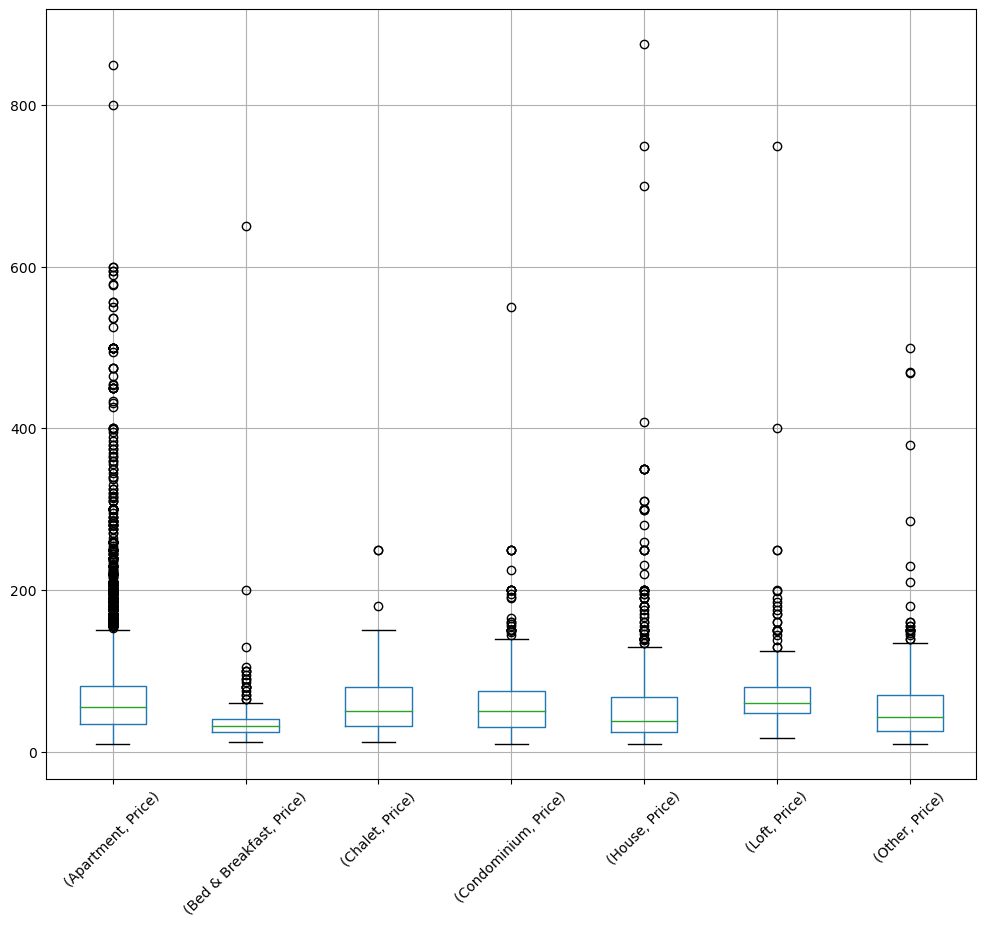

In [92]:
df.groupby('Property Type')[['Property Type', 'Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)

<AxesSubplot: >

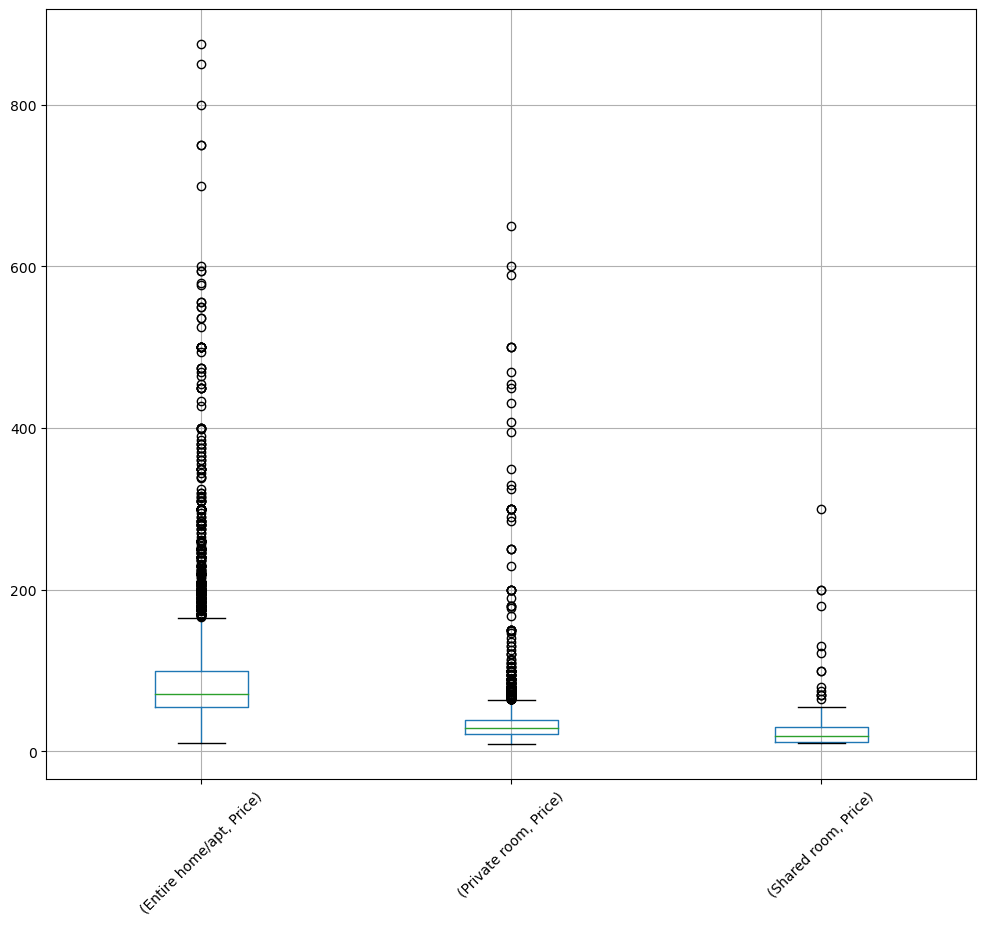

In [93]:
df.groupby('Room Type')[['Room Type', 'Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)

<AxesSubplot: >

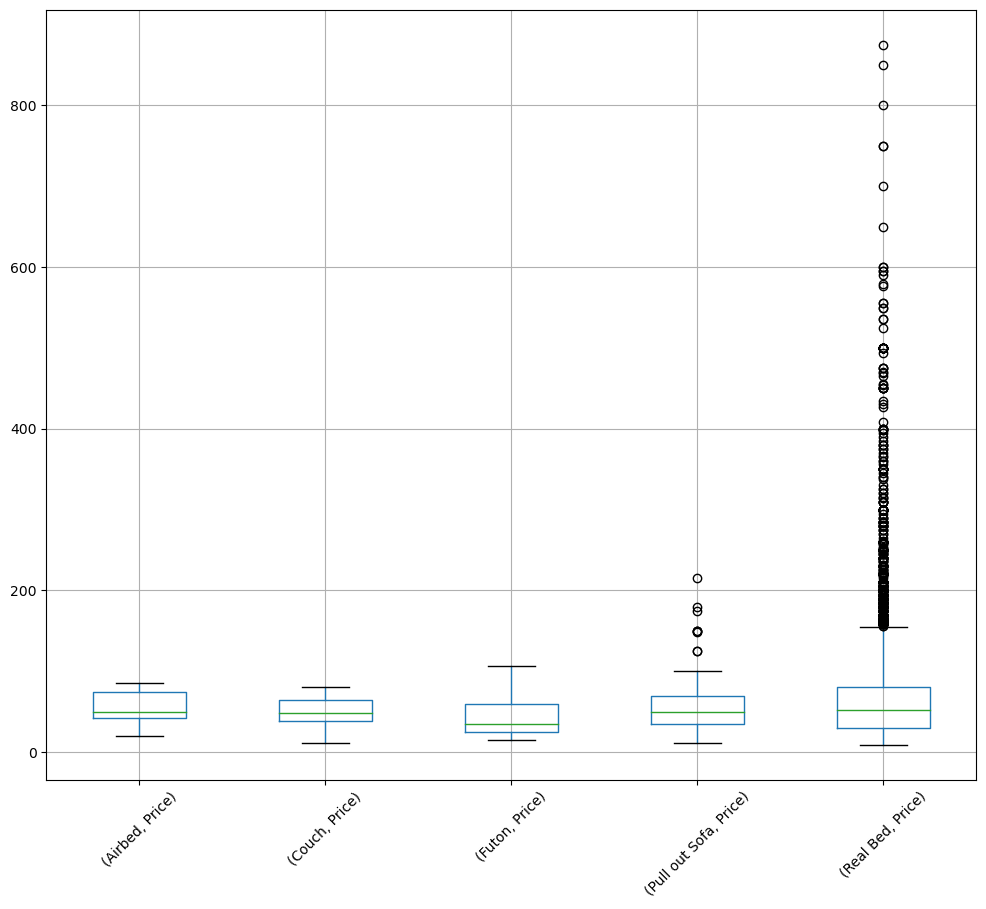

In [94]:
df.groupby('Bed Type')[['Price']].boxplot(subplots=False, figsize=(12, 10), rot=45)

df['Price'] = real_price.apply(np.log)
df['Price']

In [102]:
import os
print(os.environ['PATH'])

/Users/Laura/opt/anaconda3/envs/newConda/bin:/Users/Laura/opt/anaconda3/condabin:/usr/local/bin:/usr/bin:/bin:/usr/sbin:/sbin:/Library/Apple/usr/bin


real_price = df['Price']
